In [3]:
using Pkg
Pkg.activate("../EEG_plots/env")

  Activating project at `c:\Users\Vlad\Projects\EEG_plots\env`


# 0. Packages and data

In [120]:
import Pkg; Pkg.status()

Status `C:\Users\Vlad\Projects\EEG_plots\env\Project.toml`
⌃ [13f3f980] CairoMakie v0.9.4
  [35d6a980] ColorSchemes v3.20.0
  [5ae59095] Colors v0.12.10
  [8f4d0f93] Conda v1.7.0
  [a93c6f00] DataFrames v1.4.4
⌃ [e9467ef8] GLMakie v0.7.4
  [6a3955dd] ImageFiltering v0.7.3
  [033835bb] JLD2 v0.4.29
⌅ [ee78f7c6] Makie v0.18.4
  [b98c9c47] Pipe v1.3.0
⌃ [6c5003b2] PyMNE v0.1.2
  [6099a3de] PythonCall v0.9.10
  [ebc72ef8] SciPy v0.1.4
  [2913bbd2] StatsBase v0.33.21
  [3eaba693] StatsModels v0.6.33
  [2bdbdf9c] TopoPlots v0.1.3
  [181c99d8] Unfold v0.3.13
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [9]:
using Pkg; Pkg.add(PackageSpec(name="PyMNE", version="0.1.2"))#update("Makie")
#Pkg.add("Unfold")

   Resolving package versions...


    Updating `C:\Users\Vlad\Projects\EEG_plots\env\Project.toml`
⌃ [6c5003b2] ↓ PyMNE v0.2.0 ⇒ v0.1.2
    Updating `C:\Users\Vlad\Projects\EEG_plots\env\Manifest.toml`


⌃ [6c5003b2] ↓ PyMNE v0.2.0 ⇒ v0.1.2
        Info Packages marked with ⌃ have new versions available and may be upgradable.


In [76]:
list = ["Unfold", "CairoMakie", "GLMakie",  
"Pipe", "LinearAlgebra", "TopoPlots", 
"PyMNE", "StatsBase", "ColorSchemes"] # "JLD2","ColorSchemes", "Colors", "AbstractPlotting"]
 
for i in list
    print(i, '\n')
    Pkg.add(i);
end 

In [110]:
Pkg.add("StatsModels")

   Resolving package versions...


    Updating `C:\Users\Vlad\Projects\EEG_plots\env\Project.toml`
  [3eaba693] + StatsModels v0.6.33
  No Changes to `C:\Users\Vlad\Projects\EEG_plots\env\Manifest.toml`

In [87]:
Pkg.update("")

    Updating registry at `C:\Users\Vlad\.julia\registries\General.toml`


  No Changes to `C:\Users\Vlad\Projects\EEG_plots\env\Project.toml`
  No Changes to `C:\Users\Vlad\Projects\EEG_plots\env\Manifest.toml`


In [116]:
using Unfold
using CairoMakie
using GLMakie
using Pipe
using LinearAlgebra
using TopoPlots
using PyMNE
using StatsBase # mean/std

using JLD2 # loading data
#using ColorSchemes
using Colors
using DataFrames # for image
using ImageFiltering # for kernel
using StatsModels # UnfoldFit

In [8]:
# for pymne
begin
    using Conda
    Conda.PYTHONDIR
    using PyCall
    run(`$(PyCall.python) -m pip install pymatreader`);
    run(`$(PyCall.python) -m pip install mne`);
    @pyimport pymatreader; 
    @pyimport mne;
end; 

LoadError: LoadError: UndefVarError: @pyimport not defined
in expression starting at c:\Users\Vlad\Projects\EEG_plots\8plots.ipynb:9

In [12]:
# not sure are they really needed
using Unfold
using InteractiveDynamics
using GLMakie
using PyMNE # MNE is a python library for EEG data analysis
using AlgebraOfGraphics # plotting Grammar of Graphics
using CSV
using DataFrames
using StatsBase # mean/std
using FileIO # loading data
using JLD2 # loading data
using StatsModels # UnfoldFit
using CairoMakie # Plotting Backend (SVGs/PNGs)
using Printf # interpolate strings
using DataFramesMeta # @subset etc. working with DataFrames
using StatsPlots
using Pipe
using UnfoldMakie
using ColorSchemes
using Query
using PyCall
using ImageFiltering
using CategoricalArrays
using LinearAlgebra
using Conda

In [23]:
begin # load  one single-subject dataset 
	#p = "../../../../store/users/ehinger/projects/unfoldjl_dev/dev/UnfoldMakie/artifact/sub-002_ses-N170_task-N170_eeg.set"
	p = "../EEG_plots/data/sub-002_ses-N170_task-N170_eeg.set"
    raw = PyMNE.io.read_raw_eeglab(p,preload=true)
	#p_all = "../../../../store/users/ehinger/projects/unfoldjl_dev/data/erpcore-N170.jld2"
    p_all = "../EEG_plots/data/erpcore-N170.jld2"
	presaved_data = load(p_all)
	dat_e = presaved_data["data_e_all"].* 1e6
	evt_e = presaved_data["df_e_all"]
	mon = PyMNE.channels.make_standard_montage("standard_1020")
	raw.set_channel_types(Dict("HEOG_left"=>"eog","HEOG_right"=>"eog","VEOG_lower"=>"eog"))
	raw.set_montage(mon,match_case=false)
	pos = PyMNE.channels.make_eeg_layout(get_info(raw)).pos
	pos = [Point2f(pos[k,1],pos[k,2]) for k in 1:size(pos,1)]
end;

┌ Warning: saved type DataFrames.DataFrame is missing field metadata in workspace type; reconstructing
└ @ JLD2 C:\Users\Vlad\.julia\packages\JLD2\1YVED\src\data\reconstructing_datatypes.jl:164


In [119]:
begin
	# times vector (from-to)
	times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)

	# get standard errors
	se_solver =(x,y)->Unfold.solver_default(x,y,stderror=true)
	# define effect-coding
	contrasts= Dict(:category => DummyCoding(), :condition => DummyCoding())
	
	analysis_formula = @formula 0 ~ 1 + category * condition
	
	results_allSubjects = DataFrame()
	
	for sub ∈ unique(evt_e.subject)

		# select events of one subject
	    sIx = evt_e.subject .== sub;

		# fit Unfold-Model
		# declaring global so we can access the variable outside of this loop (local vs. global scope)
	    global mres = Unfold.fit(UnfoldModel, 
						analysis_formula, 
						evt_e[sIx,:], 
						dat_e[:,:,sIx], 
						times, 
						contrasts=contrasts,
						solver=se_solver);

		# make results of one subject available
		global results_onesubject = coeftable(mres);

		# concatenate results of all subjects
	    results_onesubject[!,:subject] .= sub;
	    append!(results_allSubjects, results_onesubject);
	    
	end;
	
end;

ErrorException: type ##DataFrames.DataFrame#313 has no field subject

In [26]:
Makie.inline!(true)
#CairoMakie.activate!(type="jpeg")

true

# 1. Lineplot

In [124]:
evt_e.subject


ErrorException: type ##DataFrames.DataFrame#313 has no field subject

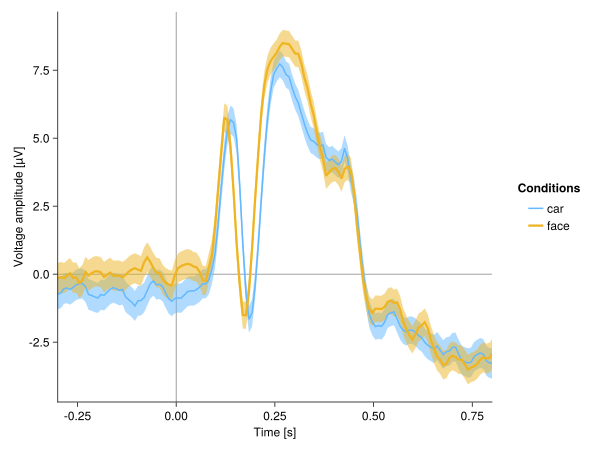

In [19]:
let
        times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)
        data = filter(x -> x.coefname == "category: face" || x.coefname == "(Intercept)", results_allSubjects) 
        data.coefname = replace(Adata.coefname, "category: face" => "face", "(Intercept)" => "car")
        nusbject = length(unique(data[!, "subject"]))
        
        data = @pipe data |> 
                groupby(_, :channel) |> # baseline correction using lambda function 
                transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> 
                rename!(_, :estimate_time_function => :estimate_bsln_corrected) |>
                @subset(_, :channel .== 28) |> 
                rename!(_, :coefname => :conditions) |> 
                groupby(_, [:time, :conditions]) |> 
                @transform!(_, :estimate_mean = mean(:estimate_bsln_corrected), :stderror_mean = 2*(mean(:stderror)./sqrt(nusbject)))|> 
                @subset(_, :subject .== 1)  |> 
                select(_, Not([:basisname, :group, :channel, :subject, :estimate, :estimate_bsln_corrected, :stderror])) |>
                groupby(_, :time) |>
                @transform!(_, :sum_mean = sum(:estimate_mean))|> 
                @transform!(_, :sum_band = sum(:stderror_mean))|> 
                @subset(_, :conditions .== "car") 


        f = Figure()
        ax = f[1, 1] = Axis(f,
                xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
        hlines!(0, color = :gray, linewidth = 1)
        vlines!(0, color = :gray, linewidth = 1)
        band!(data.time, data.estimate_mean - data.stderror_mean, data.estimate_mean + data.stderror_mean, color = (:steelblue1, 0.5)) #colormap=:viridis)
        band!(data.time, data.sum_mean - data.stderror_mean, data.sum_mean + data.stderror_mean, color = (:goldenrod2, 0.5))
                
        lines!(data.time, data.estimate_mean, label = "car", color = :steelblue1, linewidth = 2)
        lines!(data.time, data.sum_mean, label = "face",  color = :goldenrod2, linewidth = 3)

        CairoMakie.xlims!(-0.3,0.8)
        f[1, 2] = Legend(f, ax, "Conditions", framevisible = false) 
        hidespines!(ax, :t, :r) # delete unnecessary spines (lines)
        hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 
        f
        #save("plots/plot1.svg", f)
end


- band transparency
- baseline correction
- change the way of computin of bands because we need another level of uncertainty



# 2. Butterfly plot

In [28]:
# color setting
function eegHeadMatrix(positions, center, radius)
    oldCenter = mean(positions)
    oldRadius, _ = findmax(x-> LinearAlgebra.norm(x .- oldCenter), positions)
    radF = radius/oldRadius
    return Makie.Mat4f(radF, 0, 0, 0,
                       0, radF, 0, 0,
                       0, 0, 1, 0,
                       center[1]-oldCenter[1]*radF, center[2]-oldCenter[2]*radF, 0, 1)
end

struct NullInterpolator <: TopoPlots.Interpolator
        
end

function (ni::NullInterpolator)(
        xrange::LinRange, yrange::LinRange,
        positions::AbstractVector{<: Point{2}}, data::AbstractVector{<:Number})

    return zeros(length(xrange),length(yrange))
end
function posToColor(pos)
    cx = 0.5 - pos[1]
    cy = 0.5 - pos[2]
    rx = cx * 0.7071068 + cy * 0.7071068
    ry = cx * -0.7071068 + cy * 0.7071068
    b = 1.0 - (2*sqrt(cx^2+cy^2))^2
    return RGB(0.5 - rx*1.414, 0.5 - ry*1.414, b)
end

posToColor (generic function with 1 method)

In [125]:
# new
let 
    f = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98))#, resolution = (1500, 700))
    times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)
    # interaction
    xs = range(-0.3, length=size(dat_e, 2), step=1 ./ 128)  

    # butterfly plot
    ax = Axis(f[1:2,1], xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
    N = 1:length(pos) #1:4 
    hidespines!(ax, :t, :r) 
    GLMakie.xlims!(-0.3, 1.2)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)
    specialColors = ColorScheme(vcat(RGB(1,1,1.),[posToColor(pos) for pos in pos[N]]...))
    for i in N
        mean_trial = mean(dat_e[i,:,:], dims=2)[:,1]
        lines!(times, mean_trial, color = specialColors[i])
    end 

    hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 

    # text
    #vlines!(time,  color = :red, linewidth = 1)
    #text!(time, 8, text = str,  align = (:center, :center))
      # topoplot 
      topo_axis = Axis(f[1:2,2], width = 80, height = 80, aspect = DataAspect())
      Makie.xlims!(low = -0.2, high = 1.2)
      Makie.ylims!(low = -0.2, high = 1.2)
  
      topoMatrix = eegHeadMatrix(pos[N], (0.5, 0.5), 0.5)
      
      topoplot = eeg_topoplot!(topo_axis, N, # go from 1:npos
          string.(N); 
          positions = pos[N],
          # interpolation=NullInterpolator(), # inteprolator that returns only 0
          colorrange = (0, length(pos)), # add the 0 for the white-first color
          enlarge=1,
          colormap = specialColors,
          head = (color=:black, linewidth=1, model = topoMatrix))
  
      hidedecorations!(current_axis())
      hidespines!(current_axis())

    f
    #save("plots_jpg/plot2.jpg", f)
end

issue
- NullInerpolator doesn't work properly

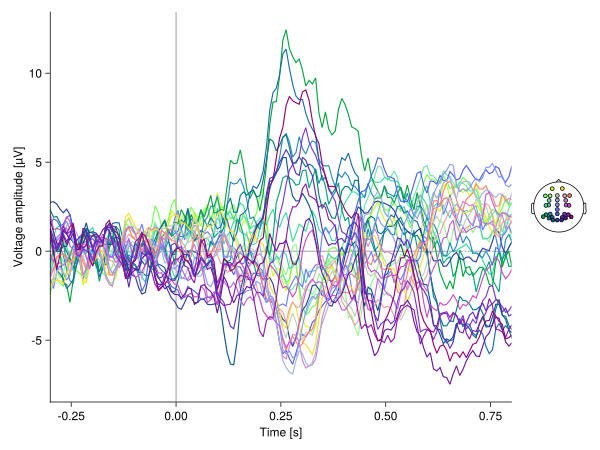

In [94]:
# old
let 
    data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        @subset(_, :channel .< 32 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)

    f = Figure()
    ax = Axis(f[1:2,1], xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
    
    N = 1:length(pos) #1:4 
    hidespines!(ax, :t, :r) 
    CairoMakie.xlims!(-0.3,0.8)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)

    specialColors = ColorScheme(vcat(RGB(1,1,1.),[posToColor(pos) for pos in pos[N]]...))

    for i in N
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected, color = specialColors[i])
    end 
    hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 

    topo_axis = Axis(f[1:2,2], width = 78, height = 78, aspect = DataAspect())

	Makie.xlims!(low = -0.2, high = 1.2)
	Makie.ylims!(low = -0.2, high = 1.2)
    topoMatrix = eegHeadMatrix(pos[N], (0.5, 0.5), 0.5)
    
    topoplot = eeg_topoplot!(topo_axis, N, # go from 1:npos
        string.(N); 
        positions = pos[N],
        interpolation=NullInterpolator(), # inteprolator that returns only 0
        colorrange = (0, length(pos)), # add the 0 for the white-first color
        colormap = specialColors,
        head = (color=:black, linewidth=1, model = topoMatrix))

    hidedecorations!(current_axis())
    hidespines!(current_axis())

    f
    #save("plots/plot2.svg", f)
end

- topoplot do not react on the change of channel numbers

# 3. Single topoplot

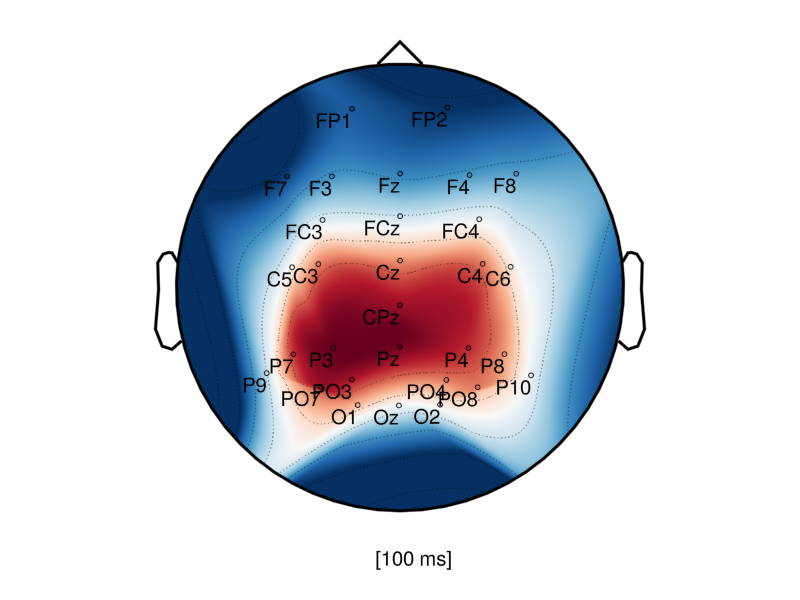

In [81]:
let 
    t = 100
    eeg_topoplot(mean(dat_e[1:30, t, :], dims=2)[:,1], # averaging all trial of 30 participants on 100th msec
        raw.ch_names[1:30]; 
        positions=pos, # produced  automatically from ch_names
        label_text=true,
        axis=(aspect=DataAspect(),)) # aspect ratio, correlation of height and width
 


    current_figure()
    f = current_figure()
    text!(0.5, -0.2,  text = "[" .* string.(t).* " ms]", align = (:center, :center))

    hidedecorations!(current_axis())
    hidespines!(current_axis()) 

    f
    #save("plots_jpg/plot3.2.jpg", f)
end


- TopoPlot library should be updated soon -> pull request new unregistered yet version

# 4. Topographic map

In [82]:
let
    # still waiting for update
    TopoPlots.eeg_topoplot_series(mean(dat_e[1:30, :, :],dims=3)[:, :, 1], 
    40, 
    topoplotCfg=(positions=pos,)
    
    )
    f = current_figure()
    ax = Axis(f[1, 1:5])
    chaLeng = 5
    x = Array(55:120:600)
    t = Array(-0.3:0.4:1.5)
    text!(x, fill(35, chaLeng),  text = "[" .* string.(t).* " s]", align = (:center, :center))
    
    Makie.xlims!(low = 0, high = 600)
    Makie.ylims!(low = 0, high = 110)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 
    f
    #save("plots_jpg/plot4.jpg", f)
end


UndefVarError: UndefVarError: eeg_topoplot_series not defined

In [36]:
let
    # golden version
    TopoPlots.eeg_topoplot_series(mean(dat_e[1:30, :, :],dims=3)[:, :, 1], 
    40, 
    topoplotCfg=(positions=pos,)
    
    )
    f = current_figure()
    ax = Axis(f[1, 1:5])
    chaLeng = 5
    x = Array(55:120:600)
    t = Array(-0.3:0.4:1.5)
    text!(x, fill(35, chaLeng),  text = "[" .* string.(t).* " s]", align = (:center, :center))
    
    Makie.xlims!(low = 0, high = 600)
    Makie.ylims!(low = 0, high = 110)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 
    f
    #save("plots_jpg/plot4.jpg", f)
end

- fork current version of TopoPlot and merge #3 and #20
- remove current version of TopoPlot
- add https://github.com/vladimir/TopoPlots.jl 

# 5. Topoplot array

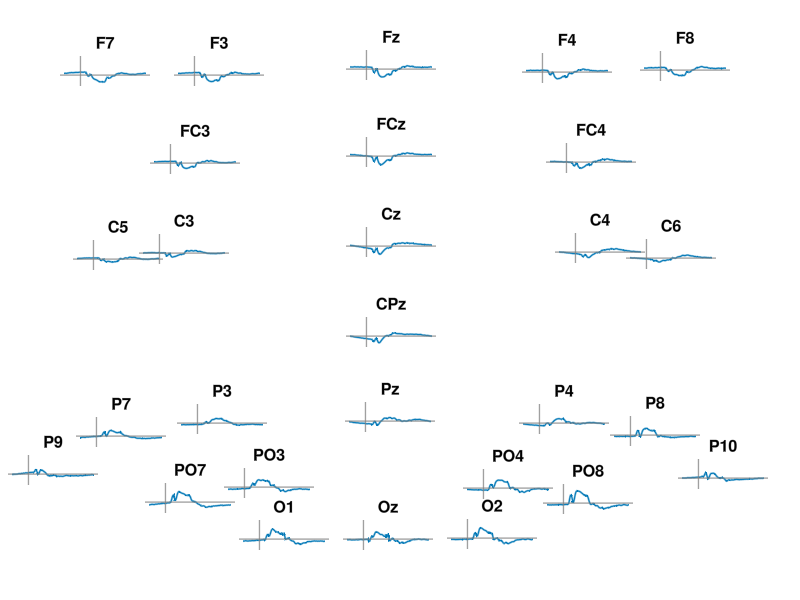

In [83]:
begin
    times = range(-0.3, length=size(dat_e, 2), step=1 ./ 128)

    f = Figure()
    for i in 1:30
        xmove = pos[i][1] *1000 - 120
        ymove =  pos[i][2]  * 800 - 100
        ax = Axis(f, bbox = BBox(xmove, xmove+90, ymove, ymove+30), title = string(raw.ch_names[i]))
        mean_trial = mean(dat_e[i,:,:], dims=2)[:,1]
        lines!(ax, times, mean_trial,  color = "#0077b6") #, model = m4x4)
        hlines!(0, color = :gray, linewidth = 1)
        vlines!(0, color = :gray, linewidth = 1)
        hidespines!(ax) 
        hidedecorations!(ax)
        Makie.ylims!(low = -8, high = 14)
    end
    f
    #save("plots_jpg/plot5.jpg", f)
end

- coordinate lines to indicate where is zero for time ad voltage - vline is badly alligned

# 6. ERP image
only for 1 channel

In [97]:
size( dat_e) # channels, time, trials

(33, 193, 8576)

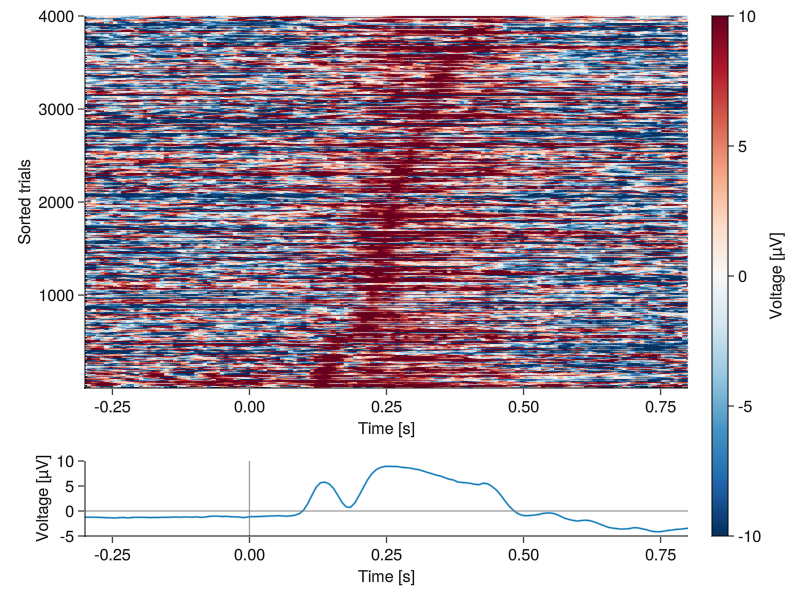

In [91]:
let
    f = Figure()
    ga = f[1, 1] = GridLayout()

    ax1 = Axis(ga[1:4, 1], xlabel = "Time [s]", ylabel = "Sorted trials")
    ix = sortperm([a[1] for a in argmax(dat_e[28,:,:], dims=1)][1,:])    # ix - trials sorted by time of maximum spike

    xs = range(-0.3, 1.2, length = size(dat_e, 2))
    ys = 1:4000
    zs = Matrix(DataFrame(dat_e[30,:,ix][:, 2000:6000], :auto))
    hm = CairoMakie.heatmap!(xs, ys, zs, colormap=Reverse("RdBu"), colorrange = (-10, 10))  
    CairoMakie.xlims!(-0.3,0.8)
    
    ax2 = Axis(ga[5, 1], xlabel = "Time [s]", ylabel = "Voltage [µV]")
    ys2 = mean(dat_e[28,:,ix],dims=2)[:,1]
    xs2 = range(-0.3, 1.2, length = size(dat_e, 2))
    lines!(ax2, xs2, ys2)
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.ylims!(-5, 10)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    
    CairoMakie.Colorbar(f[:, end+1], hm, label = "Voltage [µV]") 
    hidespines!(ax1, :t, :r)  
    hidespines!(ax2, :t, :r)  
    hidedecorations!(ax2, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots_jpg/plot6.jpg", f)
end

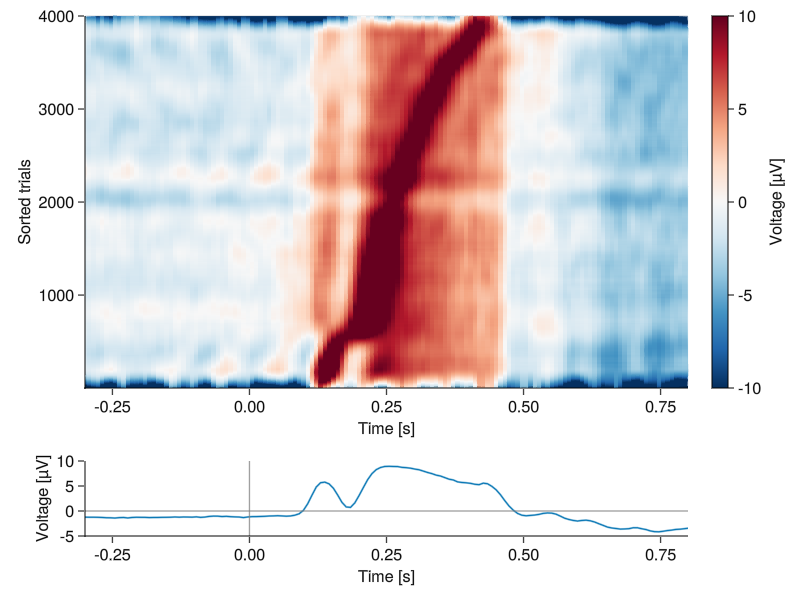

In [96]:
let
    f = Figure()
    ga = f[1, 1] = GridLayout()

    ax1 = Axis(ga[1:4, 1], xlabel = "Time [s]", ylabel = "Sorted trials")
    ix = sortperm([a[1] for a in argmax(dat_e[28,:,:], dims=1)][1,:])    # ix - trials sorted by time of maximum spike

    xs = range(-0.3, 1.2, length = size(dat_e, 2))
    #ys = 1:size(dat_e[28,:,:])[2]
    ys = 1:4000
    zs = Matrix(DataFrame(dat_e[30,:,ix][:, 2000:6000], :auto))

    zs = imfilter(zs, Kernel.gaussian((0, 100))) # @bycol - apply for each column
    #@show(size(zs))
    hm = CairoMakie.heatmap!(xs, ys, zs, colormap=Reverse("RdBu"), colorrange = (-10, 10))  
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.Colorbar(ga[:, end+1], hm, label = "Voltage [µV]") 
    
    ax2 = Axis(ga[5, 1], xlabel = "Time [s]", ylabel = "Voltage [µV]")
    ys2 = mean(dat_e[28,:,ix],dims=2)[:,1]
    xs2 = range(-0.3, 1.2, length = size(dat_e, 2))
    lines!(ax2, xs2, ys2)
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.ylims!(-5, 10)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    

    hidespines!(ax1, :t, :r)  
    hidespines!(ax2, :t, :r)  
    hidedecorations!(ax2, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots_jpg/plot6.jpg", f)
end

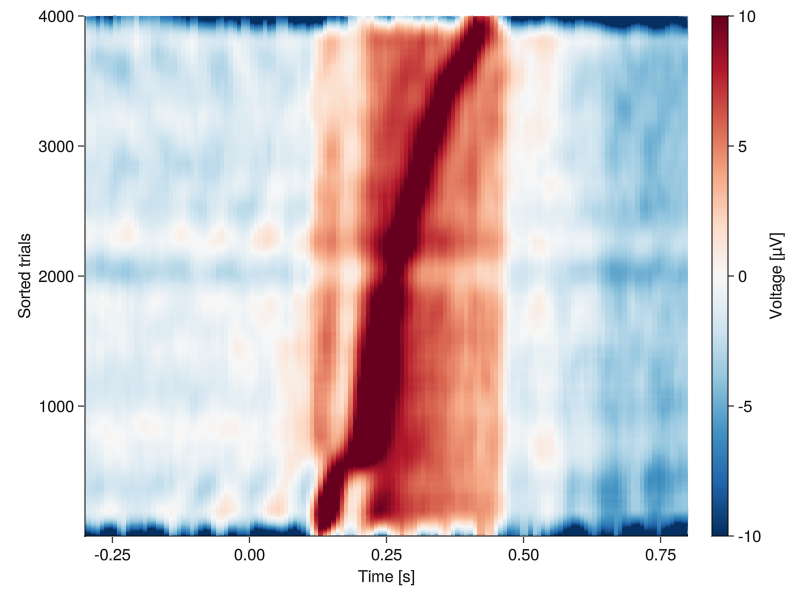

In [97]:
# without subplot
let
    f = Figure()
    ga = f[1, 1] = GridLayout()

    ax1 = Axis(ga[1, 1], xlabel = "Time [s]", ylabel = "Sorted trials")
    ix = sortperm([a[1] for a in argmax(dat_e[28,:,:], dims=1)][1,:])    # ix - trials sorted by time of maximum spike

    xs = range(-0.3, 1.2, length = size(dat_e, 2))
    #ys = 1:size(dat_e[28,:,:])[2]
    ys = 1:4000
    zs = Matrix(DataFrame(dat_e[30,:,ix][:, 2000:6000], :auto))

    zs = imfilter(zs, Kernel.gaussian((0, 100))) # @bycol - apply for each column
    #@show(size(zs))
    hm = CairoMakie.heatmap!(xs, ys, zs, colormap=Reverse("RdBu"), colorrange = (-10, 10))  
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.Colorbar(ga[:, end+1], hm, label = "Voltage [µV]") 
    

    hidespines!(ax1, :t, :r)  
    hidedecorations!(ax1, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots_jpg/plot6.jpg", f)
end

In [296]:
# to check correctness of the kernel smoothing
img = zeros(5,5); img[3,3] = 1

kern2 = KernelFactors.gaussian((100, 0))
imfilter(img, kern2)


5×5 Matrix{Float64}:
 0.0  0.0  0.00417641  0.0  0.0
 0.0  0.0  0.00417703  0.0  0.0
 0.0  0.0  0.00417724  0.0  0.0
 0.0  0.0  0.00417703  0.0  0.0
 0.0  0.0  0.00417641  0.0  0.0


- add smoothing by row, not by row and col


# 7. Channel image

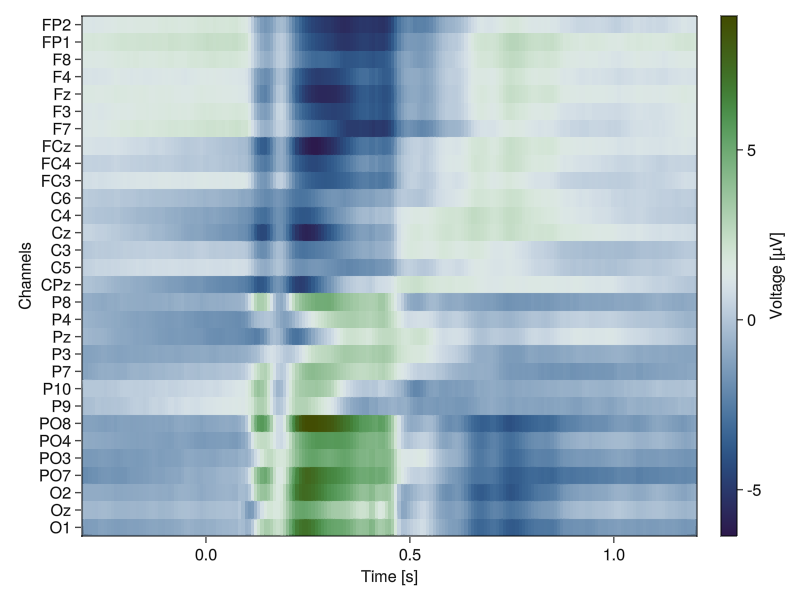

In [98]:
let 
    x = [i[1] for i in pos]
    y = [i[2] for i in pos]
    
    x = round.(x; digits=2)
    y = Integer.(round.((y .- mean(y))  * 20)) * -1
    x = Integer.(round.((x .- mean(x))  * 20))
    d = zip(x, y, raw.ch_names, 1:30)
    a = sort!(DataFrame(d), [:2, :1], rev=[true, false])
    b = a[!, :4]
    c = a[!, :3]
    
    ix = range(-0.3, 1.2, length = size(dat_e, 2))
    iy = 1:30
    iz = mean(dat_e, dims=3)[b, :, 1]'
    #iz = imfilter(iz, Kernel.gaussian((1, 0)))
    f, ax, hm = CairoMakie.heatmap(ix, iy, iz, # how to reshape this into matrix???
       colormap="cork") # single trial
    ax = current_axis()
    ax.xlabel = "Time [s]"
    ax.ylabel = "Channels"
    ax.yticks = iy
    ax.ytickformat = xc -> c

    Colorbar(f[1, 2], hm,  label = "Voltage [µV]") 
    current_figure()
    #save("plots_jpg/plot8.jpg", f)
end

# 8. Parallel coordinates

In [99]:
function par_plot(data, width, height, plot)
    # channels data
    channels =  [10, 11, 14, 28, 29, 30]  
    ch = raw.ch_names[channels] 
    chaLeng = length(channels)
    
    # get a colormap for each category
    categories = unique(data.category)
    colors = Dict{String,RGBA{Float64}}()
    catLeng = length(categories)
    bord = 1 # colormap border (prevents from using outer parts of color map)
    colormap = cgrad(:roma, (catLeng < 2) ? 2 + (bord*2) : catLeng + (bord*2), categorical = true) # haline
    for i in eachindex(categories)
        setindex!(colors, colormap[i+bord], categories[i])
    end

    # limits
    limits = [] ; l_low = [] ; l_up = []
    for cha in channels
        tmp = filter(x -> (x.channel == cha),  data) 
        w = extrema.([tmp.yhat])
        append!(limits, w)
        append!(l_up, w[1][2])
        append!(l_low, w[1][1])

    end

    # scalers  
    #width = 500;   height = 30 ;     

    bottom_padding = 7
    y = fill(105, chaLeng) # height of plot

    # axes
    f = Figure()
    ga = f[1, 1] = GridLayout()
    ax = Axis(ga[1, 1:5]) 

    for i in 1:chaLeng
        x = (i - 1) / (chaLeng - 1) * width
        Makie.LineAxis(ax.scene,  limits = limits[i], # maybe consider as unique axis????
            spinecolor = :black, labelfont = "Arial", 
            ticklabelfont = "Arial", spinevisible = true,  ticklabelsvisible = false, #switch, 
            minorticks = IntervalsBetween(2),  #tickcolor = :red, 
            endpoints = Point2f[(x, bottom_padding), (x, height)],
            ticklabelalign = (:right, :center), labelvisible = false)
    end
    
    # line scaling
    for time in unique(data.time) 
        tmp1 = filter(x -> (x.time == time),  data) #1 timepoint, 10 rows (2 conditions, 5 channels) 
        for cat in categories
            # df with the order of the channels
            dfInOrder = data[[],:]
            tmp2 = filter(x -> (x.category == cat),  tmp1)
            
            # create new dataframe with the right order
            for cha in channels
                append!(dfInOrder, filter(x -> (x.channel == cha),  tmp2))
            end
            
            values = map(1:chaLeng, dfInOrder.yhat, limits) do q, d, l # axes, data
                z = (q - 1) / (chaLeng - 1) * width
                Point2f(z,  (d - l[1]) ./ (l[2] - l[1]) * (height-bottom_padding) + bottom_padding)     
                    end
            lines!(ax.scene, values; color = colors[cat])
        end
    end 

    # axis labels 
    ax.xlabel = "Channels";    ax.ylabel = "Voltage amplitude [µV]"
    x = Array(15:(width-15)/(chaLeng-1):width) # the width of the plot is set, so the labels have to be placed evenly
    
    text!(x, y, text = ch, align = (:right, :center), # channels lables
        offset = (0, 0), 
        color = :blue) 
    text!(x, fill(3, chaLeng), align = (:right, :center),  text = string.(round.(l_low, digits=1))) # lower limit lables
    text!(x, fill(100, chaLeng), align = (:right, :center),  text = string.(round.(l_up, digits=1))) # upper limit lables
    
    # text legend
    Makie.xlims!(low = -20, high = 500)
    Makie.ylims!(low = 0, high = 110)    
    hidespines!(ax) 
    hidedecorations!(ax, label = false) 

    # legend
    ax2 = Axis(ga[1, 6]) 
    for cat in categories # helper, cuz without them they wouldn't have an entry in legend
        lines!(ax2, 1, 1, 1, label = cat, color = colors[cat])
    end

    # legend adjustment 
    axislegend(ax2, position = :rc, framevisible = false)
    hidespines!(ax2) 
    hidedecorations!(ax2, label = false) 

    # experimental
    w = @lift widths($(ax.scene.px_area))[1]
    h = @lift widths($(ax.scene.px_area))[2]
   # println(w, " ", h) 
    Makie.colgap!(ga, 2)
    if plot == true
        save("plots/plot7.jpg", f)
    end
    f 
end

par_plot (generic function with 1 method)

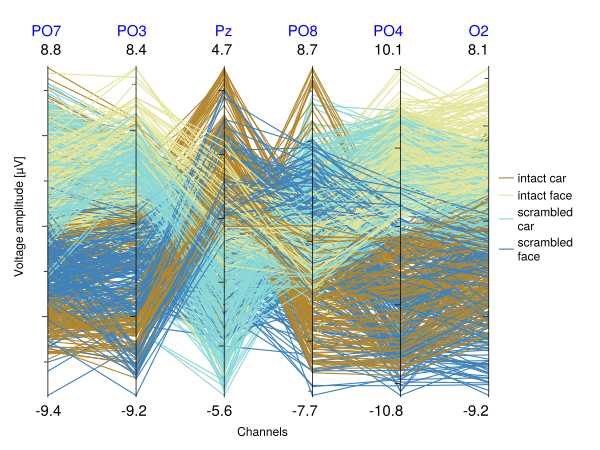

In [96]:
let

        data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        rename!(_, :coefname => :category, :estimate => :yhat) #= |>
        @subset(_, :category .!= "(Intercept)") |>
        @subset(_, :category .!= "category: face & condition: scrambled") =#


        data.category = recode(data.category, "(Intercept)" => "intact car", "category: face" => "intact face",
        "condition: scrambled" => "scrambled\ncar" , "category: face & condition: scrambled" => "scrambled\nface")
        
        #unique(data.category)

        # width, height
        par_plot(data, 493,  95, false)
end

- crowdiness: 1) transperansy 2) averaging across subjects?
- issue on makie
- try data from lineplots


- smoothing function could help to incease a resolution
- try data from lineplot

# Data

In [ ]:
let 
    #first(results_onesubject[:, !1], 5)
    #unique(results_onesubject[:, 2])
    data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        @subset(_, :channel .== 18) |>
        @transform(_, :channel = string.(:channel)) 
    data = filter(x -> x.coefname == "category: face" || x.coefname == "category: scrambled" , 
    data) 

    data
end